In [1]:
import docplex.cp.utils as utils
from docplex.cp.utils import *
from docplex.cp.expression import CpoVariable, CpoIntVar, CpoFloatVar, CpoIntervalVar, CpoSequenceVar, CpoStateFunction, \
    INT_MIN, INT_MAX, INTERVAL_MIN, INTERVAL_MAX, POSITIVE_INFINITY, NEGATIVE_INFINITY, \
    _domain_iterator, _domain_min, _domain_max, _domain_contains, \
    compare_expressions
from docplex.cp.parameters import CpoParameters
import types
from collections import OrderedDict
import functools

import docplex as dp
from docplex.cp.model import CpoModel
from sys import stdout

import pandas as pd
import numpy as np
import random
from collections import defaultdict
import math

print('Setup Complete')

Setup Complete


In [2]:
def cost_matrix(cust_data):
    cm = cust_data.iloc[0:total_cust]
    cm.columns = [str(i) for i in range(total_cust)]
    cm = cm.astype(int)
    return cm

def time_windows(cust_data):
    time_windows = cust_data.iloc[total_cust:(total_cust*2), 0:2]
    time_windows = time_windows.rename(columns={str(total_cust): 'Ei' , 'Unnamed: 1' : 'Li'}) 
    Ei = np.array(time_windows.iloc[:,0]).astype(int)
    Li = np.array(time_windows.iloc[:,1]).astype(int)
    return Ei, Li, time_windows

def mult_time_windows(originaltw):
    mult = originaltw/120
    mult = mult.round(0).astype(int)
    mult = mult*120
    return mult

'''Creating all necessary tuples'''
def necessary_tuples(total_cust, n_costmatrix, Ei, Li):   
    # Service time tuples
    serv = []
    for i in range(total_cust):
        for j in range(total_cust):
            if i==j:
                serv = serv + [(i,n_costmatrix.iloc[i,j]),]

    # Customer tuple list (COST MATRIX IN TUPLE FORMAT (i,j,Cij))
    c = []
    for i in range(total_cust):
        for j in range(total_cust):
            c = c + [(i,j,n_costmatrix.iloc[i,j]),]   

    #Time Windows in the order (Node(V), Time Window Opens (Ei), Time Window Closes (Li))
        #Time Windows in the order (Node(V), Time Window Opens (Ei), Time Window Closes (Li))
    tw = []
    for i in range(total_cust):
        tw = tw + [(i, myround(Ei[i]), myround(Li[i])-1)]

    return serv, c, tw

def myround(x, base=60):
    return base * round(x/base)

    
def sampled_customers(k, main_dict):
    sampled_c = dict(random.sample(main_dict.items(), k))
    return sampled_c

def building_probabilities(timewindowslist):
    weights = [0]
    
    if len(timewindowslist) == 10:
        if timewindowslist[0] == 0:
            timewindowslist[0] = [[0,0]]
            weights = [1]
        else:
            weights = [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
    
    if len(timewindowslist) == 5:
        a = timewindowslist[1][1]/sum([timewindowslist[1][1], timewindowslist[2][1], timewindowslist[3][1], timewindowslist[4][1]])
        b = timewindowslist[2][1]/sum([timewindowslist[1][1], timewindowslist[2][1], timewindowslist[3][1], timewindowslist[4][1]])
        c = timewindowslist[3][1]/sum([timewindowslist[1][1], timewindowslist[2][1], timewindowslist[3][1], timewindowslist[4][1]])
        weights = [0, a , b ,c , 0]
    
    if len(timewindowslist) == 9:
        weights = [0, 1, 1, 1, 1, 1, 1, 1, 0]
    
    if len(timewindowslist) == 1:
        weights = [1]
    
    return weights

# Creating transition matrix for the sampled customers 

def sampled_customers_data(k, n_costmatrix):
    
    r = list(sampled_customers(k, main_dict).keys())
    if 0 not in r:
        r = r[:-1]
        r.append(0)

    r.sort()

    sample_cust_transition_cost = []
    for i in r:
        cust = np.asarray(n_costmatrix.iloc[lambda x: x.index == i, r])
        sample_cust_transition_cost.append(cust)

    '''Cost Matrix for sampled customers'''
    dataframe_sampled_cust= pd.DataFrame(sample_cust_transition_cost[i][0] for i in range(len(sample_cust_transition_cost)))
    dataframe_sampled_cust = dataframe_sampled_cust.rename(columns = {i: r[i] for i in range(len(r))})
    dataframe_sampled_cust = dataframe_sampled_cust.rename(index= {i: r[i] for i in range(len(r))})

    '''Tuple set for the Docplex model'''
    
    c_s = []
    for i in range(k):
        for j in range(k):
            c_s = c_s + [(i,j, dataframe_sampled_cust.iloc[i,j]),]   
    
    # Creating timewindows for the sampled customers
    a1 = []
    b1 = []
    for i in r: 
        a1.append(main_dict[i][0])
        b1.append(main_dict[i][1])

    time_windows = pd.DataFrame({'et': a1 , 'lt':b1}, index = dataframe_sampled_cust.index)
    df3 = pd.DataFrame([[0, 960]], columns=['et', 'lt'])
    time_windows = time_windows.append(df3, ignore_index= False) 

    Ei_sampled_customers = np.asarray(time_windows.et) 
    Li_sampled_customers = np.asarray(time_windows['lt'])
    
    pre = creating_precedence_list(r, Qi, Wi)
    
    return r, dataframe_sampled_cust, time_windows, Ei_sampled_customers, Li_sampled_customers, pre, c_s

def driver_time_bucket(cc_sol):
    time_bucket = []
    lower_limit = [0, 120, 240, 360, 480, 600, 720, 840]
    upper_limit = lower_limit[1:]
    for i in tn:
        for j in range(8):
            if lower_limit[j] <= i <= upper_limit[j]-1:
                time_bucket.append(j)
                time_bucket_observed = [[a,b] for a, b in zip(cc_sol, time_bucket)]
                    
    return time_bucket_observed

def build_software_solutions(cc_sol_ntw, dataframe_sampled_cust):
    cc_sol_ntw = cc_sol_ntw[:-1]
    
    soft_solution = []
    for i in cc_sol_ntw:
        soft_solution.append(dataframe_sampled_cust.columns[i])   

    return soft_solution

def build_driver_solutions(cc_sol, dataframe_sampled_cust):
    cc_sol = cc_sol[:-1]
    
    drivers_route_observed = []
    for i in cc_sol:
        drivers_route_observed.append(dataframe_sampled_cust.columns[i])
    
    return drivers_route_observed

def broken_pairs(nbofcustomers, software_solution, drivers_route_observed):    
    pairs_driver_route = []
    pairs_software_route = []

    for i in range(nbofcustomers-1):
        pairs_software_route = pairs_software_route + [(software_solution[i],software_solution[i+1]),]

    for j in range(nbofcustomers-1):
        pairs_driver_route = pairs_driver_route + [(drivers_route_observed[j],drivers_route_observed[j+1]),]
    
    broken_pairs_list = []
    valid_pair_list = []
    for i in range(nbofcustomers-1):
        if pairs_software_route[i] not in pairs_driver_route:
            broken_pairs_list.append(pairs_software_route[i])
        else:
            valid_pair_list.append(pairs_software_route[i])
    return len(broken_pairs_list), broken_pairs_list, valid_pair_list

def jarvis_solution_space(total_cust):
    new_solution_space = []
    for i in range(0, total_cust):
        h = [i ,[1,0],[2,0],[3,0], [4,0], [5,0], [6,0], [7,0], [8,0], [9,0]]
        new_solution_space.append(h)
    
    return new_solution_space

def creating_precedence_list(r, Wi, Qi):
    precedence_list = []
    cust_list= []
    for i in range(len(r)-1):
        if r[i] in Qi:
            t = Qi[i]
            v = Wi[Qi[i]]
            precedence_list.append(v)
            cust_list.append(t)
    
    return precedence_list, cust_list

def possible_time_windows(observedtw, jarvis_solution_space):
    all_possible_tw = []
    for i in observedtw:
        if i[0] == 0:
            possible_tw = [[0,0]]                
        if len(jarvis_solution_space[i[0]]) < 3:
            possible_tw = [i[0], [1,0], [2,0], [3,0] , [4,0], [5,0], [6,0] , [7,0], [8,0]] 
        if len(jarvis_solution_space[i[0]]) > 3 and i[0] != 0:
               possible_tw = jarvis_solution_space[i[0]] 
        
        all_possible_tw.append(possible_tw)
               
    return all_possible_tw

def jarvis_observe(tn, cc_sol): # Time node and customer solution
    time_bucket = []
    for i in tn:
        time_bucket.append(math.ceil(i/120))

    time_bucket_observed = [[a,b] for a, b in zip(cc_sol, time_bucket)]
    
    return time_bucket_observed

def jarvis_picks_tw(all_possible_tw, k, observedtw):
    
    jarvis_suggests = []
    
    all_weights = []
    
    jarvis_picks = []
    
    for y in range(k):
        
        w = building_probabilities(all_possible_tw[y])
        
        all_weights.append(w)
        
        sut = random.choices(all_possible_tw[y], weights = all_weights[y], cum_weights= None ,k=1) # add weights here for probability!  
        
        if sut[0][0] == 0:
            cust = all_possible_tw[y][0]
        else:
            cust = [all_possible_tw[y][0], sut[0][0]]
        
        jarvis_picks.append(cust)
        
        #p = sorted(jarvis_picks, key= lambda tw: tw[1])  
    
    jarvis_suggests.append(jarvis_picks)
    
    return jarvis_picks,sut

def jarvis_eliminates_1(observedtw, jarvis_solutionspace):
    k = []
    for i in observedtw: 
        for j in range(1, 10):
            if len(jarvis_solutionspace[i[0]]) > 6 and jarvis_solutionspace[i[0]][j][0] == i[1]: 
                m = jarvis_solutionspace[i[0]][0]
                q = jarvis_solutionspace[i[0]][9]
                a = jarvis_solutionspace[i[0]][j]  

                if j == 1:
                    n = jarvis_solutionspace[i[0]][j+1]
                    p = jarvis_solutionspace[i[0]][j+2]
                if j == 10:
                    n = jarvis_solutionspace[i[0]][j-2]
                    p = jarvis_solutionspace[i[0]][j-1]
                if 1 < j < 10:
                    n = jarvis_solutionspace[i[0]][j-1]
                    p = jarvis_solutionspace[i[0]][j+1]
                
                a[1] = a[1]+1 
                jarvis_solutionspace[i[0]] = [m, n, a, p, q]
                k.append(m)   
    return jarvis_solutionspace,k


def jarvis_eliminates_2(observedtw, jarvis_solutionspace, cut_customers):
    
    for i in observedtw: 
        
        cut_cust_2 = []
        
        if len(jarvis_solutionspace[i[0]]) == 5 and i[0] not in cut_customers:       
                
                if i[1] == jarvis_solutionspace[i[0]][1][0]:
                    jarvis_solutionspace[i[0]][1][1] = jarvis_solutionspace[i[0]][1][1]+1
                
                if i[1] == jarvis_solutionspace[i[0]][2][0]:
                    jarvis_solutionspace[i[0]][2][1] = jarvis_solutionspace[i[0]][2][1]+1
                
                if i[1] == jarvis_solutionspace[i[0]][3][0]:
                    jarvis_solutionspace[i[0]][3][1] = jarvis_solutionspace[i[0]][3][1]+1
                
                b = [jarvis_solutionspace[i[0]][1][0],jarvis_solutionspace[i[0]][2][0],jarvis_solutionspace[i[0]][3][0]]
                
                if i[1] not in b and i[0] != jarvis_solutionspace[i[0]][1][1] :
                    
                    print('For Customer', i[0], 'time window', i[1], 'was not found in the solution space', jarvis_solutionspace[i[0]][1], jarvis_solutionspace[i[0]][2], jarvis_solutionspace[i[0]][3], '!!!!!!!!!')
                    
                    jarvis_solutionspace[i[0]] = [jarvis_solutionspace[i[0]][0], jarvis_solutionspace[i[0]][4]]
                    
                    jarvis_solutionspace[i[0]][1][1] = int(jarvis_solutionspace[i[0]][1][1]) + 1
                    
                    cut_cust_2 = [jarvis_solutionspace[i[0]][1][0]]
            
        if len(jarvis_solutionspace[i[0]]) == 2 and i[1] not in cut_cust_2:
                jarvis_solutionspace[i[0]][1][1] = int(jarvis_solutionspace[i[0]][1][1]) + 1
                print("Jarvis proposes a full day for customer", i[0])
    
    return jarvis_solutionspace

In [3]:
def software_solution(nbofcustomers, c_s):
    cpmdl_ntw = CpoModel()
    
    '''Creating decision variables'''
    transitionCost_ntw = cpmdl_ntw.integer_var_list(size= nbofcustomers, min=0, max=100000, name="transitionCost_ntw")
    current_cust_ntw = cpmdl_ntw.integer_var_list(size= (nbofcustomers+1), min=0, max=nbofcustomers , name='current_cust_ntw')
    
    '''Adding Constraints'''
    for i in range(0, nbofcustomers):
        aux_vars_ntw = (current_cust_ntw[i],current_cust_ntw[i+1], transitionCost_ntw[i])
        cpmdl_ntw.add(cpmdl_ntw.allowed_assignments(aux_vars_ntw, c_s))
        
    cpmdl_ntw.add(current_cust_ntw[0] == 0)
    
    cpmdl_ntw.add(current_cust_ntw[nbofcustomers] == 0)
    
    cpmdl_ntw.add(cpmdl_ntw.all_diff(current_cust_ntw[1:]))
     
    '''Objective Function'''
    cost_ntw = sum(transitionCost_ntw)
    cpmdl_ntw.add(cpmdl_ntw.minimize(cost_ntw))
    
    '''Solving'''
    myparams = CpoParameters(TimeLimit = 1000)
    sol_ntw = cpmdl_ntw.solve(params = myparams)
    software_time = sol_ntw.get_solve_time()
    
    # Storing values of retrieved variables
    global tc_ntw 
    tc_ntw = []
    for j in range(0,nbofcustomers):
        k= sol_ntw.get_value(transitionCost_ntw[j])
        tc_ntw.append(k)

    global cc_sol_ntw
    cc_sol_ntw = []
    for p in range(0,nbofcustomers+1):
        d=sol_ntw.get_value(current_cust_ntw[p])
        cc_sol_ntw.append(d)
    
    return cc_sol_ntw, tc_ntw,software_time

        
def drivers_route(nbofcustomers, Ei, Li, Qi, Wi, c_s): 
    serv_time = [0]
    for i in range(nbofcustomers-1):
        serv_time.append(10)
        
    # Creating the Model
    cpmdl = CpoModel()

    #Creating Decision Variables
    time_node = [cpmdl.integer_var(min=Ei[i], max=Li[i] , name= 'nodevisitimeallowed'+str(i)) for i in range(0,nbofcustomers+1)]
    transitionCost = cpmdl.integer_var_list(size=(nbofcustomers), min=0, max=10000, name="transitionCost")
    current_cust = cpmdl.integer_var_list(size=(nbofcustomers+1), min=0, max=nbofcustomers , name='current_cust')
    '''Time at which service starts at any node '''
    time_node_visit = cpmdl.integer_var_list(size=(nbofcustomers+1), name='Time at Customer')

    #Creating Constraints
    #1
    '''Strong constraints imposing the allowed values of transition cost'''
    for i in range(0, nbofcustomers):
        aux_vars = (current_cust[i], current_cust[i+1], transitionCost[i])
        cpmdl.add(cpmdl.allowed_assignments(aux_vars, c_s))
    #2
    cpmdl.add(current_cust[0] == 0)
    #3
    cpmdl.add(current_cust[nbofcustomers] == 0)
    #4
    cpmdl.add(cpmdl.all_diff(current_cust[1:]))
    #5
    for i in range(0,nbofcustomers):
        cpmdl.add(sum([time_node_visit[i],serv_time[i],transitionCost[i]])<=(time_node_visit[i+1]))
    #6
    cpmdl.add(time_node_visit[0] == 0)
    #7
    cpmdl.add(cpmdl.all_diff(time_node_visit))
    
    #8: Forcing the model to take time_node index for current_cust [i]
    for i in range(1,nbofcustomers+1):
        cpmdl.add(time_node_visit[i] == cpmdl.element(time_node, current_cust[i]))
    #10
    for i in Qi:
        for j in Wi:
            cpmdl.add((time_node_visit[[j]] < time_node_visit[i]))

    #9 
    cpmdl.add(cpmdl.search_phase(current_cust))

    # Objective Function
    cost = sum(transitionCost)
    cpmdl.add(cpmdl.minimize(cost))

    #Solve 
    myparams = CpoParameters(TimeLimit = 1000)
    msol = cpmdl.solve(params = myparams)
    driver_time = msol.get_solve_time()
    
    # Storing values of retrieved variables
    global tc
    #tc = []
    #for j in range(0,nbofcustomers):
    #    b=msol.get_value(transitionCost[j])
    #    tc.append(b)
    
    global cc_sol
    cc_sol = []
    for p in range(0,nbofcustomers+1):
        d= msol.get_value(current_cust[p])
        cc_sol.append(d)
    
    global tn
    tn = []
    for i in range(0,nbofcustomers+1):
        a= msol.get_value(time_node_visit[i])
        tn.append(a)
    
    global sol
    sol = []
    p = msol.get_objective_values()
    sol.append(p)
    
    
    return cc_sol, tn, driver_time

In [4]:
def improved_route_jarvis(nbofcustomers, time_buckets, c_s, customers_with_time_windows): 

    # Creating the Model
    cpmdl = CpoModel()

    #Creating Decision Variables 
    
    time_node = [cpmdl.integer_var(min= 0, max= 8 , name= 'nodevisitimeallowed'+str(i)) for i in range(0,nbofcustomers)]
    
    transitionCost = cpmdl.integer_var_list(size=(nbofcustomers), min=0, max=10000, name="transitionCost")
    
    current_cust = cpmdl.integer_var_list(size=(nbofcustomers+1), min=0, max=nbofcustomers , name='current_cust')
    
    '''Time at which service starts at any node '''
    time_node_visit = cpmdl.integer_var_list(size=(nbofcustomers+1), min=0, max =8, name='Time at Customer')
     
    
    
    '''Creating list of customers with time windows'''
    cust_with_tw = []
    
    for i in range(len(time_buckets)):
        for j in range(len(customers_with_time_windows)):
            if time_buckets[i][0] == customers_with_time_windows[j]:
                cwtw = i
                cust_with_tw.append(cwtw)
            
    time_bucket = [time_buckets[i][1] for i in range(len(time_buckets))] # For the depot
    
    #Creating Constraints
    #1
    '''Strong constraints imposing the allowed values of transition cost'''
    for i in range(0, nbofcustomers):
        aux_vars = (current_cust[i], current_cust[i+1], transitionCost[i])
        cpmdl.add(cpmdl.allowed_assignments(aux_vars, c_s))
    #2
    cpmdl.add(current_cust[0] == 0)
    #3
    cpmdl.add(current_cust[nbofcustomers] == 0)
    #4
    cpmdl.add(cpmdl.all_diff(current_cust[1:]))
    #5
    
    #6
    cpmdl.add(time_node_visit[0] == 0)
    
    cpmdl.add(time_node_visit[nbofcustomers] == 8)
    
    #for i in range(1,nbofcustomers+1):
    #    cpmdl.add(time_node_visit[i] == time_bucket[i])
    
    for i in range(nbofcustomers):
        cpmdl.add(time_node_visit[i] <= time_node_visit[i+1])
    
    for i in cust_with_tw:
        cpmdl.add(time_node_visit[i] == cpmdl.element(time_bucket, current_cust[i]))
    
    
    #9 
    cpmdl.add(cpmdl.search_phase(current_cust))
    
                
    # Objective Function
    cost = sum(transitionCost)
    cpmdl.add(cpmdl.minimize(cost))

    #Solve 
    myparams = CpoParameters(TimeLimit = 1000)
    msol = cpmdl.solve(params = myparams)
    jarvis_time = msol.get_solve_time()
    
    # Storing values of retrieved variables
    global tc
    #tc = []
    #for j in range(0,nbofcustomers):
    #    b=msol.get_value(transitionCost[j])
    #    tc.append(b)
    
    global cc_sol
    cc_sol = []
    for p in range(0,nbofcustomers+1):
        d= msol.get_value(current_cust[p])
        cc_sol.append(d)
    
    global sol
    sol = []
    p = msol.get_objective_values()
    sol.append(p)
    
    
    return cc_sol, jarvis_time

In [5]:
# Main Customer list data

main_customer_data = pd.read_excel('RC 204.1.xlsx')
total_cust = 46
main_cost_matrix = cost_matrix(main_customer_data)
main_time_windows = time_windows(main_customer_data)
multiples_time_windows = mult_time_windows(main_time_windows[2])
Ei_mult = mult_time_windows(time_windows(main_customer_data)[0])
Li_mult = mult_time_windows(time_windows(main_customer_data)[1])
serv_c_tw = necessary_tuples(total_cust, main_cost_matrix, main_time_windows[0], main_time_windows[1])

In [6]:
from collections import defaultdict
Vi = defaultdict(list)
for i in range(total_cust):
    for j in range(total_cust):
        if i!=j and main_time_windows[0][i] >= main_time_windows[1][j]:
            Vi[i].append(j)

Qi = list(Vi.keys())
Wi = []
for i in Vi:
    l =  Vi[i]
    Wi.append(l)

In [7]:
Wi

[[24, 33, 43],
 [7, 18, 24, 33, 39, 43],
 [7, 8, 18, 24, 33, 36, 39, 43],
 [33, 43],
 [43],
 [7, 8, 18, 24, 33, 36, 39, 43],
 [43],
 [7, 18, 24, 33, 39, 43],
 [7, 18, 24, 33, 39, 43],
 [24, 33, 43],
 [7, 8, 18, 24, 33, 36, 39, 43]]

In [8]:
# All Customers with their time windows- Main customer dictionary
main_dict = {serv_c_tw[2][i][0]:(serv_c_tw[2][i][1],serv_c_tw[2][i][2]) for i in range(total_cust)}

In [9]:
# Defining Jarvis and the solution space. 
main_jarvis_list = jarvis_solution_space(total_cust) # As a List
main_jarvis_dict = {i:[[1,0],[2, 0],[3, 0], [4,0], [5, 0], [6, 0], [7, 0], [8, 0], [9,0]] for i in range(total_cust)}

##### Starting the DAY

In [10]:
# On Day 1, lets have 12 customers:
'''2.  Initialize Days : Day 1'''
def instance(k):
    
    customers_with_time_windows = []
    full_day_customers = []
    
    # Service time - Can ignore (only works after defining k) 

    '''2.1 Sample k customers'''
    day_1 = sampled_customers(k, main_dict)
    day_sampled_customers_data = sampled_customers_data(k, main_cost_matrix)

    '''2.2 Check if driver solution exist'''

    driver_sol = drivers_route(k, day_sampled_customers_data[3], day_sampled_customers_data[4],
                              day_sampled_customers_data[5][1], day_sampled_customers_data[5][0], day_sampled_customers_data[6])
    print('We solved drivers route')
    driver_tim = driver_sol[2]
    
    driver_route_taken = build_driver_solutions(driver_sol[0], day_sampled_customers_data[1])
    
    jarvis_day_observe = jarvis_observe(driver_sol[1], driver_route_taken)
    
    possible_tw = possible_time_windows(jarvis_day_observe, mjlcopy)
    #print('Possible TW :', possible_tw)
    
    jarvis_select = jarvis_picks_tw(possible_tw, len(possible_tw), jarvis_day_observe) #Selection from jarvis
    #print('Jarvis Selected :', jarvis_select)
    
    jarvis_select_1 = sorted(jarvis_select[0], key = lambda tb:tb[0])
    
    
    '''2.2.1 Building a list of customers with time windows'''
    
    for i in jarvis_select_1:
        if 3<len(mjlcopy[i[0]])<6:
            customers_with_time_windows.append(i[0])
        else:
            full_day_customers.append(i[0])
    
    
    
    '''2.3 Computing Software Solution and Suggesting a route based on probabilities '''

    #initially all probabilities (or weights) = 0

    soft_sol = software_solution(k, day_sampled_customers_data[6])
    print('We solved software route')
    
    soft_time = soft_sol[1]
    
    software_route_suggested = build_software_solutions(soft_sol[0], day_sampled_customers_data[1])
    
    jarvis_sol = improved_route_jarvis(k, jarvis_select_1, day_sampled_customers_data[6], customers_with_time_windows)
    
    print('Jarvis has solved the route')
    
    jarvis_route_suggested = build_software_solutions(jarvis_sol[0] , day_sampled_customers_data[1])
    
    jarvis_time = jarvis_sol[1]   #soft_sol[2]

    
    
    '''2.5 Jarvis Learns Through Action Elimination'''
    
    jarvis_elim_1 = jarvis_eliminates_1(jarvis_day_observe, mjlcopy)
    customers_cut = jarvis_elim_1[1]
    jarvis_elim_2 = jarvis_eliminates_2(jarvis_day_observe, jarvis_elim_1[0], customers_cut)
    
    
    
    return jarvis_elim_1, jarvis_elim_2, jarvis_day_observe, customers_cut, jarvis_select, driver_sol, jarvis_time, driver_tim, jarvis_route_suggested, driver_route_taken, customers_with_time_windows, soft_time, software_route_suggested

    


In [11]:
mjlcopy = main_jarvis_list.copy()
testing_results = []
nbcusts = []
tests = 100
for i in range(tests):
    #anyrand = random.randint(9,12)
    anyrand = 10
    try:
        testing = instance(anyrand)
    except KeyError:
        print("We found that instance", i, "was not feasible !")
        pass
    
    testing_results.append(testing)
    nbcusts.append([anyrand])
    print(i)

We solved drivers route
We solved software route
Jarvis has solved the route
0
We solved drivers route
We solved software route
Jarvis has solved the route
1
We solved drivers route
We solved software route
Jarvis has solved the route
For Customer 27 time window 7 was not found in the solution space [4, 0] [5, 1] [6, 0] !!!!!!!!!
Jarvis proposes a full day for customer 27
2
We solved drivers route
We solved software route
Jarvis has solved the route
For Customer 31 time window 1 was not found in the solution space [2, 0] [3, 1] [4, 0] !!!!!!!!!
Jarvis proposes a full day for customer 31
3
We solved drivers route
We solved software route
Jarvis has solved the route
For Customer 15 time window 1 was not found in the solution space [2, 1] [3, 1] [4, 0] !!!!!!!!!
Jarvis proposes a full day for customer 15
For Customer 38 time window 2 was not found in the solution space [4, 0] [5, 1] [6, 0] !!!!!!!!!
Jarvis proposes a full day for customer 38
Jarvis proposes a full day for customer 27
4
We

In [12]:
jarvis_selection_withtw = []
jarvis_solution = []
driver_route_withtw = []
jarvis_solve_time = []
driver_solve_time = []
software_solve_time = []
twcustomer_list = []
software_route = []

In [13]:
all_sugges = []
all_driver_routes = []
for i in range(tests):
    sugges = []
    for p in range(0, nbcusts[i][0]):
        sugges.append(testing_results[i][4][0][p][0])
    all_sugges.append(sugges)
    all_driver_routes.append(testing_results[i][9])
    jarvis_selection_withtw.append(testing_results[i][4])
    driver_route_withtw.append(testing_results[i][2])
    jarvis_solve_time.append(testing_results[i][6])
    driver_solve_time.append(testing_results[i][7])
    jarvis_solution.append(testing_results[i][8])
    twcustomer_list.append(testing_results[i][10])
    software_route.append(testing_results[i][12])
    software_solve_time.append(testing_results[i][11])

In [14]:
#for i in range(tests):
    #print(software_solve_time[i],'seconds for', nbcusts[i][0], 'customers')

In [15]:
#for i in range(tests):
    #print(driver_solve_time[i],'seconds for', nbcusts[i][0], 'customers')

In [16]:
def incorrect_suggestions(tests, driver_route_withtw, jarvis_selection_withtw):
    nb_of_incorrect_suggestions = []

    for i in range(tests):
        b = []
        a = 0
        for j in range(len(driver_route_withtw[i])):
            if jarvis_selection_withtw[i][0][j] not in driver_route_withtw[i] and jarvis_selection_withtw[i][0][j][1] != 9:
                print('Jarvis has made a mistake in the instance',i,'. The time window', jarvis_selection_withtw[i][0][j][1], 'for customer', jarvis_selection_withtw[i][0][j][0], 'does not exist in the drivers solution space')
                a = a + 1
                c = [i]

        nb_of_incorrect_suggestions.append(c)    
        nb_of_incorrect_suggestions.append(a)
    
    return nb_of_incorrect_suggestions

In [17]:
def correct_suggestions(tests, driver_route_withtw, jarvis_selection_withtw, mjlcopy):
    
    nb_of_correct_suggestions = []
    c = 0
    for i in range(0, tests):
        b = []
        a = 0
        for j in range(len(driver_route_withtw[i])):
            if jarvis_selection_withtw[i][0][j] in driver_route_withtw[i] and 2< len(mjlcopy[driver_route_withtw[i][j][0]])<8:
                a = a + 1
                c = [i, nbcusts[i]]
                #nb_of_correct_suggestions.append([jarvis_selection_withtw[i][0][j]])
    
        nb_of_correct_suggestions.append([c,a])    
        
    
    return nb_of_correct_suggestions

In [18]:
def accurate_suggestions(tests, driver_route_withtw, jarvis_selection_withtw, mjlcopy):
    
    nb_of_accurate_suggestions = []
    c = 0 
    for i in range(0, tests):
        b = []
        a = 0
        for j in range(len(driver_route_withtw[i])):
            if jarvis_selection_withtw[i][0][j] in driver_route_withtw[i] and 2<len(mjlcopy[driver_route_withtw[i][j][0]])<8:
                a = a + 1
                c = [i, [len(twcustomer_list[i])]]
                #nb_of_correct_suggestions.append([jarvis_selection_withtw[i][0][j]])
    
        nb_of_accurate_suggestions.append([c,a])    
        
    
    return nb_of_accurate_suggestions

In [19]:
twcustomer_list

[[],
 [34],
 [7, 20, 27, 41],
 [15, 18, 24, 29, 31],
 [15, 17, 38],
 [12, 19, 24, 33, 44],
 [12, 16, 24, 32, 37, 42],
 [4, 9, 16, 20, 21, 42, 43],
 [13, 16, 17, 26, 36, 37, 39],
 [13, 14, 17, 41],
 [7, 11, 12, 13, 19, 22, 33, 36],
 [7, 18, 24, 35, 37, 41, 43],
 [2, 12, 18, 21, 34, 40, 41],
 [3, 5, 10, 20, 43],
 [2, 3, 8, 40, 45],
 [7, 17, 25, 29, 43, 45],
 [1, 6, 23, 24, 37, 43],
 [1, 14, 24, 37, 39],
 [22, 29, 36, 37, 45],
 [8, 17, 29, 36, 43, 44],
 [17, 18, 29, 34, 37, 40, 45],
 [8, 37, 45],
 [7, 30, 36, 39],
 [19, 28, 36, 44],
 [17, 20, 33],
 [8, 17, 39],
 [8, 23, 29],
 [1, 30, 36],
 [33, 36, 39],
 [33, 43],
 [33, 45],
 [18, 29, 39, 43],
 [7, 17, 24, 37],
 [14],
 [7, 8, 17, 39],
 [7, 33],
 [7, 14, 36],
 [8, 36],
 [14, 20, 36],
 [7, 24, 37, 39, 45],
 [1, 17, 36, 45],
 [7, 24, 33],
 [14, 36, 43],
 [24, 36, 43],
 [14, 18, 20],
 [20, 33, 36, 43],
 [7, 43],
 [1, 33, 36],
 [8, 39, 43],
 [24, 29],
 [7, 14, 39],
 [36, 39, 45],
 [37, 39],
 [18, 43, 45],
 [8, 24, 29, 43],
 [43],
 [1, 37, 43],

In [20]:
all_suggestions = correct_suggestions(tests, driver_route_withtw, jarvis_selection_withtw, mjlcopy)
all_suggestions

[[[0, [10]], 1],
 [[0, [10]], 0],
 [[2, [10]], 1],
 [[2, [10]], 0],
 [[2, [10]], 0],
 [[5, [10]], 1],
 [[6, [10]], 2],
 [[7, [10]], 1],
 [[8, [10]], 3],
 [[8, [10]], 0],
 [[10, [10]], 3],
 [[11, [10]], 4],
 [[11, [10]], 0],
 [[13, [10]], 1],
 [[14, [10]], 1],
 [[15, [10]], 2],
 [[16, [10]], 2],
 [[17, [10]], 4],
 [[18, [10]], 4],
 [[19, [10]], 3],
 [[20, [10]], 4],
 [[21, [10]], 3],
 [[22, [10]], 2],
 [[22, [10]], 0],
 [[22, [10]], 0],
 [[25, [10]], 1],
 [[26, [10]], 2],
 [[27, [10]], 1],
 [[28, [10]], 2],
 [[29, [10]], 2],
 [[29, [10]], 0],
 [[31, [10]], 3],
 [[32, [10]], 3],
 [[33, [10]], 1],
 [[34, [10]], 3],
 [[35, [10]], 2],
 [[36, [10]], 1],
 [[37, [10]], 2],
 [[38, [10]], 1],
 [[39, [10]], 5],
 [[40, [10]], 2],
 [[41, [10]], 2],
 [[42, [10]], 1],
 [[43, [10]], 3],
 [[43, [10]], 0],
 [[45, [10]], 2],
 [[46, [10]], 1],
 [[47, [10]], 1],
 [[48, [10]], 1],
 [[49, [10]], 1],
 [[50, [10]], 3],
 [[51, [10]], 2],
 [[52, [10]], 1],
 [[53, [10]], 1],
 [[54, [10]], 3],
 [[55, [10]], 1],
 [

In [21]:
all_accurate_suggestions = accurate_suggestions(tests, driver_route_withtw, jarvis_selection_withtw, mjlcopy) 
all_accurate_suggestions[2][1]/all_accurate_suggestions[2][0][1][0]

0.25

In [25]:
def calc_accuracy(suggestions):
    accuracy = []
    for i in range(2, tests):
        h = suggestions[i][1]/suggestions[i][0][1][0]
        k = [(h)*100, suggestions[i][1], len(twcustomer_list[i]), nbcusts[i]]
        accuracy.append(k)
    return accuracy

In [26]:
all_accurate_suggestions

[[[0, [0]], 1],
 [[0, [0]], 0],
 [[2, [4]], 1],
 [[2, [4]], 0],
 [[2, [4]], 0],
 [[5, [5]], 1],
 [[6, [6]], 2],
 [[7, [7]], 1],
 [[8, [7]], 3],
 [[8, [7]], 0],
 [[10, [8]], 3],
 [[11, [7]], 4],
 [[11, [7]], 0],
 [[13, [5]], 1],
 [[14, [5]], 1],
 [[15, [6]], 2],
 [[16, [6]], 2],
 [[17, [5]], 4],
 [[18, [5]], 4],
 [[19, [6]], 3],
 [[20, [7]], 4],
 [[21, [3]], 3],
 [[22, [4]], 2],
 [[22, [4]], 0],
 [[22, [4]], 0],
 [[25, [3]], 1],
 [[26, [3]], 2],
 [[27, [3]], 1],
 [[28, [3]], 2],
 [[29, [2]], 2],
 [[29, [2]], 0],
 [[31, [4]], 3],
 [[32, [4]], 3],
 [[33, [1]], 1],
 [[34, [4]], 3],
 [[35, [2]], 2],
 [[36, [3]], 1],
 [[37, [2]], 2],
 [[38, [3]], 1],
 [[39, [5]], 5],
 [[40, [4]], 2],
 [[41, [3]], 2],
 [[42, [3]], 1],
 [[43, [3]], 3],
 [[43, [3]], 0],
 [[45, [4]], 2],
 [[46, [2]], 1],
 [[47, [3]], 1],
 [[48, [3]], 1],
 [[49, [2]], 1],
 [[50, [3]], 3],
 [[51, [3]], 2],
 [[52, [2]], 1],
 [[53, [3]], 1],
 [[54, [4]], 3],
 [[55, [1]], 1],
 [[56, [3]], 2],
 [[56, [3]], 0],
 [[58, [3]], 1],
 [[59, 

In [27]:
accuracy_1 = calc_accuracy(all_suggestions)
accuracy_2 = calc_accuracy(all_accurate_suggestions)

In [28]:
accuracy_1[0][0]

10.0

In [29]:
all_broken_pairs = []
for j in range(tests):
    bp = broken_pairs(nbcusts[j][0], jarvis_solution[j], all_driver_routes[j])
    all_broken_pairs.append(bp)

In [30]:
all_broken_pairs

[(9,
  [(0, 10),
   (10, 7),
   (7, 34),
   (34, 23),
   (23, 20),
   (20, 24),
   (24, 41),
   (41, 44),
   (44, 40)],
  []),
 (3,
  [(0, 31), (34, 33), (33, 38)],
  [(31, 18), (18, 34), (38, 27), (27, 29), (29, 13), (13, 42)]),
 (8,
  [(41, 12),
   (12, 11),
   (11, 27),
   (27, 7),
   (7, 20),
   (20, 15),
   (15, 17),
   (17, 21)],
  [(0, 41)]),
 (7,
  [(0, 29), (29, 39), (9, 24), (24, 16), (16, 15), (15, 18), (19, 31)],
  [(39, 9), (18, 19)]),
 (8,
  [(43, 37),
   (37, 27),
   (27, 38),
   (38, 26),
   (26, 45),
   (45, 15),
   (15, 17),
   (17, 32)],
  [(0, 43)]),
 (8,
  [(0, 44), (44, 15), (15, 19), (19, 22), (22, 24), (24, 5), (5, 33), (33, 8)],
  [(8, 12)]),
 (3,
  [(32, 16), (24, 31), (31, 4)],
  [(0, 32), (16, 24), (4, 27), (27, 37), (37, 12), (12, 42)]),
 (5,
  [(0, 36), (36, 42), (20, 6), (6, 4), (4, 9)],
  [(42, 43), (43, 21), (21, 16), (16, 20)]),
 (0,
  [],
  [(0, 17),
   (17, 15),
   (15, 16),
   (16, 26),
   (26, 39),
   (39, 36),
   (36, 37),
   (37, 14),
   (14, 13)

In [31]:
avg_broken_pairs = [all_broken_pairs[i][0] for i in range(tests)]
avg_broken_pairs_1 = [all_broken_pairs[i][0] for i in range(int(tests/5))]
avg_broken_pairs_2 = [all_broken_pairs[i][0] for i in range(int(2*tests/5))]
avg_broken_pairs_3 = [all_broken_pairs[i][0] for i in range(int(3*tests/5))]
avg_broken_pairs_4 = [all_broken_pairs[i][0] for i in range(int(4*tests/5))]

avg_broken_pairs = np.average(np.array(avg_broken_pairs))
avg_broken_pairs_1 = np.average(np.array(avg_broken_pairs_1))
avg_broken_pairs_2 = np.average(np.array(avg_broken_pairs_2))
avg_broken_pairs_3 = np.average(np.array(avg_broken_pairs_3))
avg_broken_pairs_4 = np.average(np.array(avg_broken_pairs_4))

In [32]:
print(avg_broken_pairs)
print(avg_broken_pairs_1)
print(avg_broken_pairs_2)
print(avg_broken_pairs_3)
print(avg_broken_pairs_4)

4.17
5.4
4.65
4.25
4.1


In [33]:
all_accurate_suggestions[1][1]

0

In [34]:
import seaborn as sns
y_1 = [accuracy_1[i][0] for i in range(len(accuracy_1))]
y_2 = [accuracy_2[i][0] for i in range(len(accuracy_2))]
y_3 = [nbcusts[i][0] for i in range(1, len(accuracy_1)+1)]
y_4 = [len(twcustomer_list[i]) for i in range(1, len(accuracy_1)+1)]
y_5 = [all_accurate_suggestions[i][1] for i in range(1, len(accuracy_1)+1)]
y_6 = [all_broken_pairs[i][0] for i in range(1, len(accuracy_1)+1)]
data_1 = pd.DataFrame()

C:\Users\Shubham\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
data_1['all_cust'] = y_1
data_1['tw_cust'] = y_2
data_1['total_cust'] = y_3 
data_1['timewindow_customers'] = y_4
data_1['nbofcorrectsuggestions'] = y_5
data_1['brokenpairs'] = y_6

In [46]:
omegamean = np.average(y_1)
deltamean = np.average(y_2)
print(omegamean, deltamean)

15.918367346938776 51.4346452866861


In [53]:
data_1['brokenpairs'].value_counts()

0    29
9    16
3    15
8    11
5     6
6     6
7     5
4     5
2     5
Name: brokenpairs, dtype: int64

In [61]:
verifying = data_1[data_1['brokenpairs']  == 0] 
verifying[verifying['tw_cust'] == 100]

,all_cust,tw_cust,total_cust,timewindow_customers,nbofcorrectsuggestions,brokenpairs
35,20.0,100.0,10,3,1,0
37,50.0,100.0,10,3,1,0
48,30.0,100.0,10,2,1,0
53,10.0,100.0,10,4,3,0
63,20.0,100.0,10,3,2,0
64,50.0,100.0,10,2,2,0
68,20.0,100.0,10,3,1,0
75,20.0,100.0,10,1,0,0
79,10.0,100.0,10,1,1,0
81,10.0,100.0,10,1,0,0


In [36]:
data_1

,all_cust,tw_cust,total_cust,timewindow_customers,nbofcorrectsuggestions,brokenpairs
0,10.0,25.000000,10,1,0,3
1,0.0,0.000000,10,4,1,8
2,0.0,0.000000,10,5,0,7
3,10.0,20.000000,10,3,0,8
4,20.0,33.333333,10,5,1,8
...,...,...,...,...,...,...
93,10.0,33.333333,10,3,2,6
94,30.0,100.000000,10,3,1,2
95,30.0,100.000000,10,3,3,6
96,0.0,0.000000,10,3,3,2


In [37]:
data_2 = pd.DataFrame()
data_2['tw_cust_rollingmean'] = data_1['tw_cust'].rolling(window=5).mean()
data_2['all_cust_rollingmean'] = data_1['all_cust'].rolling(window=5).mean()
data_2['bp_rollingmean'] = data_1['brokenpairs'].rolling(window=5).mean()

In [38]:
import matplotlib.pyplot as plt

(0, 150)

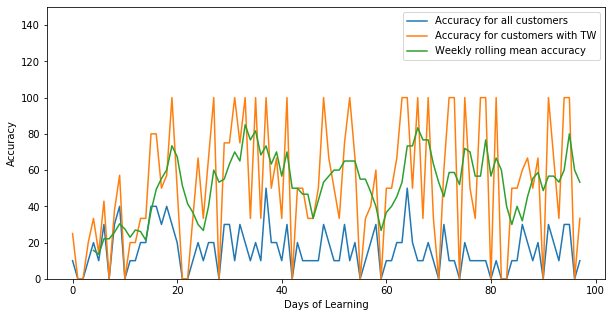

In [41]:
'''PLOT 1 - Accuracy over number of iterations'''
plt.figure(figsize= (10,5))
sns.lineplot(x = data_1.index, y = data_1.all_cust, data=data_1, markers= True, label= 'Accuracy for all customers')
sns.lineplot(x = data_1.index, y = data_1.tw_cust, data=data_1, markers= True, label= 'Accuracy for customers with TW')
sns.lineplot(x = data_1.index, y = data_2.tw_cust_rollingmean, markers= True, label= 'Weekly rolling mean accuracy')
plt.xlabel('Days of Learning')
plt.ylabel('Accuracy')
axes = plt.gca()
axes.set_ylim([0,150])

(0, 20)

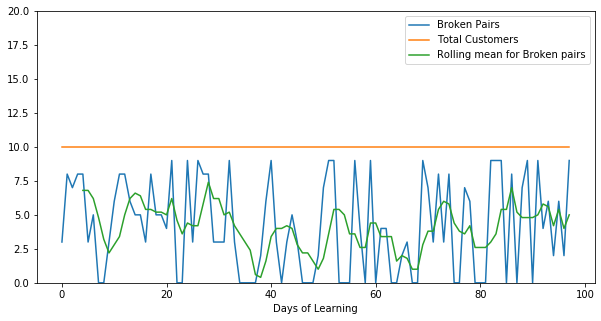

In [42]:
'''PLOT 2 - Broken pairs over number of iterations'''
plt.figure(figsize= (10,5))
sns.lineplot(x = data_1.index, y = data_1.brokenpairs, data=data_1, markers= True, label= 'Broken Pairs')
sns.lineplot(x = data_1.index, y = data_1.total_cust, data=data_1, markers= True, label = 'Total Customers')
sns.lineplot(x = data_1.index, y = data_2.bp_rollingmean, markers= True, label = 'Rolling mean for Broken pairs')
plt.xlabel('Days of Learning')
plt.ylabel('')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,20])

In [43]:
for i in range(tests):
    st = np.average(np.asarray(software_solve_time))
for i in range(tests):
    dt = np.average(np.asarray(driver_solve_time))
for i in range(tests):
    jt = np.average(np.asarray(jarvis_solve_time))

print(st, dt, jt)

30.368 1.3874594235420228 1.0054458475112915
